> # <b>*세미프로젝트*<b> 

> ## <span style = 'font-size:40px'> <b>1. 분석개요<b> </span>

### 1) 분석의 배경 및 목적 


#### 주제선정 이유 : 
배경 > 관광산업이 주인 `제주도`에는 숙박, 관광, 식당 등 관광객이 선택할 수 있는 폭이 넓다. <br>
정보의 홍수 속 관광객들은 어떤 기준으로 소비를 하는 것일까 궁금증을 갖게 되었다. <br>

의문점 > 
2019년 한 조사에 따르면, 제주도 숙소를 선택하는 기준에 대해 `합리적인 가격`에 약 40%가 응답했다. <br>


우리는 `제주도 행정구역별 숙박업의 분포`와 가격 외에도 `제주도 숙박업의 평점(만족도)에 외부적인 요인`이 개입하였는가에 대해 알아보고자 한다.  <br>

![img](./설문조사.jpg) <br>
[출처 : 데일리한국]

#### 알고자 하는 내용: 
- 호텔의 평점을 소비자의 만족도라 가정했을 때, `외부적인 요인`은 개입하였는가? <br>
<br>
외부적인 요인으로 세가지를 가정.. <br> 
<br>
*(1) 호텔 평점과 공항과의 거리(소요시간)과의 관계*  <br>
*(2) 호텔 평점과 동일 행정구역 내 관광지의 개수의 관계* <br>
*(3) 호텔 평점과 동일 행정지역 내의 음식점 개수의 관계* <br>

세 가지 외부적인 요인들을 알아보고 소비자의 만족도를 알아보고자 한다.    

### 2) 분석 범위

#### 분석의 대상 : 숙박업의 평점

| <b>분석 대상<B> | <b>분석 대상의 범위<b> |
|------------|----------------|
| `관광지`||
| `음식점`||
|`숙박업`        | 제주특별자치도 관광공사에서 제공한 숙박업 정보(2022년 데이터) 및 <br> 야놀자,마이리얼트립 크롤링데이터(조건 설정 : 2023.07.20~2023.07.26 / 성인2명)| 

*************************

>## <span style = 'font-size:40px'><b>2. 데이터 구축 및 분석 방법 </span>

### 1) 분석 프로세스

![분석프로세스](./analysis_process.png)

### 2) 데이터 수집 및 분석 방법

### <span style= 'color : blue' > *0단계 : 데이터 자료 통합본* </span>

1. 패키지 설치

In [2]:
import pandas as pd
from pandas import DataFrame, melt, read_excel
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import folium
from os import path, mkdir
import base64

import bs4
import requests
import json
import simplejson

import chromedriver_autoinstaller
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from bs4 import BeautifulSoup
import time

from IPython.display import SVG

2. 통합 데이터 (보고서에서 쓸 데이터들 총 모음)

* 데이터 통합 전처리 및 정제

In [6]:
Data1=pd.read_excel('./Database/제주관광공사_제주관광정보시스템(VISIT JEJU)_콘텐츠_20230315.xlsx') #제주도 전체 콘텐츠 데이터
Data3=pd.read_csv('./Database/NXE_3rd_ORIGIN_NXEGGRESTRTAL_20210101000000.csv') #음식점 평점
Data4=pd.read_csv('./Database/NXE_3rd_ORIGIN_NXEGGSTAYNGAL_20210101000000.csv') #숙박업 평점
Data5=pd.read_csv('./Database/NXE_3rd_ORIGIN_NXEGGTRRSRTAL_20210101000000.csv') #관광지 평점

data1=pd.DataFrame(Data1)
data3=pd.DataFrame(Data3)
data4=pd.DataFrame(Data4)
data5=pd.DataFrame(Data5)

add=[]
for x in [data3,data4,data5]:
    add.append(list(x.columns)) 
    
add=list(map(lambda x: dict(zip(["이름","구분","평점","day1"],x)),add))

result=[]
for x in [data3,data4,data5]:
    result.append(x.rename(columns=dict(zip(x.columns,["이름","구분","평점","구분1","day1","day2"]))).drop(columns=["구분1","day2"]))

for i in range(3):
    result[i]["평점"]=result[i]["평점"].astype("float") #평점 데이터가 str형태 -> 실수(float)으로 변경

* 숙박 통합 데이터<br>
아래 코딩을 음식점, 관광지에 동일 적용

In [7]:
test1=pd.DataFrame(result[1].groupby("이름")["평점"].mean())
test1.index.name="기준"
test2=data1[data1["콘텐츠분류"]=="숙박"].set_index("제목") # 콘텐츠 분류는 따로 적용
test2.index.name="기준"
test3=pd.merge(test2,test1,how="left")
test3.to_excel('./수정데이터/숙박(평점포함).xlsx') # -> 임시 저장

In [8]:
result={}
for name in ["숙박","음식점","관광지"]:
    data=pd.read_excel(f"./수정데이터/{name}(평점포함).xlsx")
    drop_cols=[data.columns[i] for i in sum([list(range(26,42)),
                                         list(range(51,73))],[])]
    drop_cols.extend(sum([
    ["웹사용여부","모바일사용여부","작성상태",'사용여부','공개여부','트립어드바이저코드','템플릿여부'],
    ["콘텐츠아이디","연관콘텐츠","외부검색어",'번역요청일시'],
    ["언어","작성상태_1","수정자","수정일시","우편번호"],
    ["웹사용여부","모바일사용여부","작성상태",'사용여부','공개여부','트립어드바이저코드','템플릿여부']],[]))
    Use_data=data.drop(columns=drop_cols)
    Use_data=Use_data[(Use_data["지번주소"].isna()==False)&(Use_data["도로명주소"].isna()==False)]
    result[name]=Use_data[Use_data["콘텐츠분류"]==name]
for name in result:
    result[name].to_excel(f"./수정데이터/{name}(최종).xlsx")

In [ ]:
for name in result:
    print(f"{name}")
    print("-"*30)
    print(result[name].info())
    print("-"*30)

![숙소통합데이터](./숙박통합데이터.png)
![음식점통합데이터](./음식점통합데이터.png)
![관광지통합데이터](./관광지통합데이터.png)

In [10]:
#제목이 없는 데이터 삭제(nan값 처리)
for name in result:
    print(f"{name}")
    print("Nan개수 : ",result[name]["타이틀"].isna().sum())
    print("-"*30)
    final=result[name]["타이틀"].dropna()
    final.to_excel(f"./수정데이터/{name}(최종).xlsx")

숙박
Nan개수 :  120
------------------------------
음식점
Nan개수 :  120
------------------------------
관광지
Nan개수 :  157
------------------------------


* 관광지, 음식점 통합데이터 : 이하동문

* [번외 : 숙박 통합데이터] Selenium 크롤링을 활용코드 : 야놀자 / 마이리얼트립 사이트

In [ ]:
# 야놀자 
url='https://www.yanolja.com/hotel/r-900584?advert=AREA&topAdvertiseMore=1&region=900584'

# 객체 생성
driver=Chrome()
driver.get('https://www.yanolja.com/hotel/r-900584?advert=AREA&topAdvertiseMore=1&region=900584') 

# 날짜는 수작업으로 설정 : 2023.07.20~2023.07.26 / 성인 2명 

# 스크롤내리기 작업
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight)")
    time.sleep(0.5)
    before_height = int(driver.execute_script("return document.body.scrollHeight"))
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight)")
    time.sleep(0.5)
    height = int(driver.execute_script("return document.body.scrollHeight"))
    if before_height==height:
        break

# html 불러오기
A=bs4.BeautifulSoup(driver.page_source)
data1=list(map(lambda x:x.attrs["title"],A.select(".PlaceListItemBanner_container__ARsIm.banner-unit a")))
data2=list(map(lambda x:x.attrs["title"],A.select('.PlaceListItemText_container__fUIgA.text-unit a')))

# 데이터 추출
y_hotellist=data1+data2

# 통합데이터 
data1 

#-------------------------------------------------------------------------------------------

# 마이리얼트립 
url='https://accommodation.myrealtrip.com/union/products?checkIn=2023-07-20&checkOut=2023-07-26&adultCount=2&childCount=0&childAges=&infantCount=0&infantAges=&regionId=&keyword=%EC%A0%9C%EC%A3%BC%EB%8F%84&roomCount=1'

# 필요한 패키지 설치 (야놀자 참조)

# 객체 생성
driver=Chrome()

# get 요청
driver.get(url)

# 스크롤 내리기
point=WebDriverWait(driver,1).until(lambda x:x.find_element(By.CSS_SELECTOR,"body"))

result=[]
while True:
    for i in range(2):
        point.send_keys(Keys.PAGE_DOWN)
    time.sleep(1)
    M=bs4.BeautifulSoup(driver.page_source).select('.css-1xdhyk6 .e12a3oa10.css-121peml')
    Now=list(set(sum([result,M],[])))
    print(Now)
    if Now==result:
        break
    result=Now

m_hotellist = []
for r in result:
    m_hotellist.append(r.text)
len(set(m_hotellist)) 

# 마이리얼트립 호텔리스트 data1에 append
for m in m_hotellist:
    if m not in data1:
        data1.append(m)

data1

# 최종 통합데이터
data1

* [번외 : 숙박 통합데이터] open api 이용한 주소 도출

In [ ]:
# OPEN API 이용한 pre_data의 주소 도출
url = "https://dapi.kakao.com/v2/local/search/keyword.json?"
key = "19111005ad4c10663591e0a55b344ba5"
query = pre_data

Data = []
for q in pre_data: 
    r = requests.get(url, params={'query':q}, headers={"Authorization": "KakaoAK 19111005ad4c10663591e0a55b344ba5"})
    js = simplejson.JSONEncoder().encode(r.json())
    result = r.json()
    Data.append(result['documents'])

# place_name과 address_name만 추출한 데이터 = processing_Data  
processing_Data=list(map(lambda x: (x[0]["place_name"],x[0]['address_name']) if x else None,Data))

# processing_Data를 데이터프레임으로 만든후 컬럼 재정의 & '숙박'xlsx으로 저장
totalData = pd.DataFrame(data=[x for x in processing_Data if x]).rename(columns={0:"place_name",1:"address_name"}).to_excel("숙박2.xlsx")
totalData

* [번외] 제주도가 아닌 곳은 제외시키는 코드

In [ ]:
data=data[data["지번주소"].str.find("제주특별")!=-1]
# data.drop(columns="Unnamed: 0",inplace=True)
data["행정구역"]=np.nan

In [43]:
행정구역 = {'구좌':'구좌',
  '조천':'조천', 
  '화북': '동제주','봉개':'동제주', '회천':'동제주','용강':'동제주',
  '오라':'중제주','아라':'중제주','오등':'중제주','화북':'중제주','이도':'중제주','건입':'중제주','삼도':'중제주','용담':'중제주','일도':'중제주', 
  '도두':'서제주','이호':'서제주','외도':'서제주','내도':'서제주','도평':'서제주','노형':'서제주','연동':'서제주','강정':'서제주','도순':'서제주',
  '영남':'서제주','월평':'서제주','해안':'서제주', '노형':'서제주',
  '애월' :'애월',
  '성산':'성산',
  '한림':'한림',
  '표선':'표선',
  '남원':'남원',
  '한경':'한경',
  '안덕':'안덕',
  '영천':'동서귀','동흥':'동서귀','효돈':'동서귀','송산':'동서귀','신효':'동서귀','하효':'동서귀','서귀':'동서귀','보목':'동서귀','동홍':'동서귀',
  '대천':'중서귀','대륜':'중서귀','서홍':'중서귀', '강정':'중서귀','법환':'중서귀','서호':'중서귀','호근':'중서귀',
  '여래':'서서귀','중문':'서서귀','회수':'서서귀', '하원':'서서귀','대포':'서서귀', '색달':'서서귀', '하예':'서서귀', '상예':'서서귀',  
  '대정':'대정'}

In [44]:
def trans(x):
    for i in 행정구역.keys():
        try:
            if i in x:
                return 행정구역[i]
        except:
            break

In [ ]:
# 지번주소
error=[]
data["행정구역"]=data["지번주소"].apply(lambda x:trans(x))
# 도로명주소
data.loc[data["행정구역"].isna(),"행정구역"]=data[data["행정구역"].isna()].apply(lambda x:trans(x))

* [번외] 4단계 상관분석 시, 카카오맵 함수 코드 사용 

In [ ]:
def KAKAO(START,FINISH):

    import bs4
    import selenium
    import chromedriver_autoinstaller
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver import Chrome
    import time
    from selenium.webdriver.common.keys import Keys
    import datetime as dt

    driver=Chrome()
    time.sleep(3)
    driver.get('https://map.kakao.com/')
    try:
        need_remove=WebDriverWait(driver,3).until(lambda x: x.find_element(By.CSS_SELECTOR,".coach_layer.coach_layer_type1 .view_coach"))
        need_remove.click()
    except:
        pass
    path_page=WebDriverWait(driver,3).until(lambda x: x.find_element(By.ID,"search.tab2"))
    path_page.click()
    try:  
        need_remove2=WebDriverWait(driver,3).until(lambda x: x.find_element(By.CSS_SELECTOR,".layer_body .desc_coach"))
        need_remove2.click()
    except:
        pass

    start=WebDriverWait(driver,3).until(lambda x: x.find_element(By.CSS_SELECTOR,".waypointWindow>input"))
    start.send_keys(Keys.ENTER)
    start.click()
    #_______________________________________________________________#
    start2=WebDriverWait(driver,3).until(lambda x: x.find_element(By.CSS_SELECTOR,".WaypointInput>input"))
    start2.send_keys(START) #출발지 입력
    start2.send_keys(Keys.DOWN)
    start2.send_keys(Keys.ENTER)
    time.sleep(1)

    finish=WebDriverWait(driver,3).until(lambda x: x.find_element(By.ID,"info.route.waypointSuggest.input1"))
    finish.send_keys("메가스터디IT 강남점") #도착지 입력
    finish.send_keys(Keys.DOWN)
    finish.send_keys(Keys.ENTER)
    time.sleep(1)

    texi=WebDriverWait(driver,3).until(lambda x: x.find_element(By.ID,"cartab"))
    texi.click()
    print("준비완료")
    #________________________<반복>________________________________________#
    final={}
    for finishs in FINISH:
        try:
            refinish1=WebDriverWait(driver,3).until(lambda x: x.find_element(By.CSS_SELECTOR,"#info .WaypointBoxView.dest .waypointWindow .valueBox"))
            refinish1.click()
            refinish2=WebDriverWait(driver,3).until(lambda x: x.find_element(By.ID,"info.route.waypointSuggest.input1"))
            refinish2.clear()
            refinish2.send_keys(finishs)
            refinish2.send_keys(Keys.ENTER)
            time.sleep(1)
            texi.click()
            time.sleep(1)
            soup=bs4.BeautifulSoup(driver.page_source)
            datas=soup.select(".contents")[0]
            info=dict.fromkeys(['time','distance','toll','taxi','oil'])
            for key in info:
                info[key]=datas.select(f".{key}")[0].text        
            final[finishs]=info
            time.sleep(1)
        except:
            continue
    return final

### <span style= 'color : blue' > *1단계 : 제주공항* </span>

1. 작업준비
- 패키지 설치 및 가져오기 `*0단계참고`

2. 지도 표현하기
* 지도 객체 생성 : 지도의 중심이 되는 위도와 경도를 설정    


In [11]:
# 1) 제주국제공항의 위도/경도 이용한 map_osm
map_osm = folium.Map(location=[33.506987985240166,126.49213025140001], zoom_start=13)
map_osm

* 제주국제공항 지도 객체(map_osm)에 사용자 옵션 추가
    *  Icon_img 옵션 <br>
    * 일반마커 and 원형마커 <br>


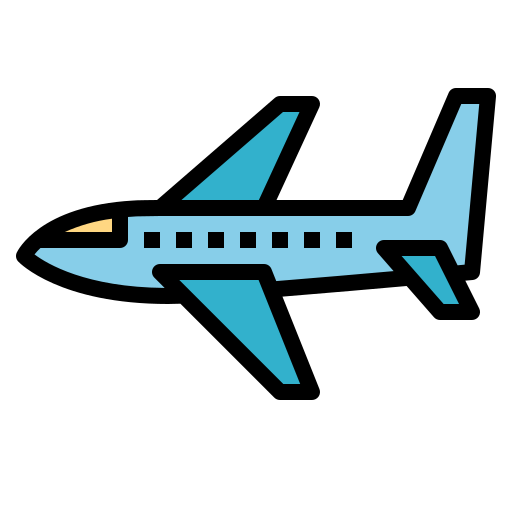

In [14]:
# 사용자 지정 아이콘 이미지 사용 : 비행기 아이콘 사용
icon_img = folium.features.CustomIcon("C:/Users/hanjieun_2/Desktop/데이터분석/공동작업소/세미_프로젝트2/airplane.png", icon_size=(100,100))

# 마커 객체 생성
marker = folium.Marker(location=[33.506987985240166,126.49213025140001], icon = icon_img)
# 원형마커
marker2 = folium.CircleMarker([33.506987985240166,126.49213025140001],
                              radius=100, #범위
                              color='#3186cc', #선 색상
                              fill_color='#3186cc' #면 색상
                              )
# 마커 객체를 지도에 추가함
marker2.add_to(map_osm)  
marker.add_to(map_osm)

                        
# 웹 페이지 파일이 저장될 폴더 생성
if not path.exists('jeju_airport_loc'):
    mkdir('jeju_airport_loc')

# 파일이 저장될 위치
map_osm.save('jeju_airport_loc/map_osm.html')

# 지도에 표시하기
map_osm

### <span style= 'color : blue' > *2단계 : 제주도 관광지 및 음식점* </span>

### <span style= 'color : blue' >제주도 관광지</span>

1.작업준비

* 데이터 가져오기 `*0단계참고-'관광지통합데이터'`

2.시각화 : SVG 시각화를 통해 관광지의 밀집도 분석

* 행정구역별 색상 리스트 만들기

In [78]:
colors = ['#e6ffff', '#99ffff', '#66ffff', '#1affff', '#00e6e6','#00cccc','#009999','#006666']

* histogram 을 이용한 구간 설정

In [79]:
# 행정구역 = index, 행정구역 별 관광지의 개수(count) = column
color_rule=pd.merge(pd.DataFrame(set(행정구역.values())).set_index(0),pd.DataFrame(data["행정구역"].value_counts()),
                    how="left",left_index=True,right_index=True).fillna(0)

x,y=np.histogram(color_rule["count"].values,bins=8)

# 구간별 색상값
dc=dict(zip(y[:-1],colors))

* 구간에 따라 색상값 변수(color_id) 추가

In [85]:
for name in color_rule.index:
    for i in y[:-1]:
        if color_rule.loc[name]['count']>=i:
            color_rule.loc[name,'color_id']=i

with open("./제주map.svg","r",encoding="utf-8") as f:
    jeju_map=f.readlines()


for name in color_rule.index:
    idx=[]
    for i in range(len(jeju_map)):
        if name in jeju_map[i]:
            idx.append(i)
    for j in map(lambda x:x+1,idx):
        jeju_map[j]=jeju_map[j].replace("#eeeeee",dc[color_rule.loc[name]["color_id"]])

with open("관광지시각화.html","w") as f:
    for line in jeju_map:
        f.write(line)

![행정구역별_관광지_분포](./관광지_시각화.png)

* 분석결과 : 행정구역별로 나누어보았을 때, 관광지는 동서귀포에 가장 밀집되어 있다. 하지만 시별(제주시, 서귀포시)로 나눌때 관광지는 서귀포시보다 제주시에 더 많이 분포되어 있다. 

### <span style= 'color : blue' >제주도 음식점</span>

1.작업준비

* 데이터 가져오기 `*0단계 참고-음식점통합데이터`

2.시각화 :SVG 시각화를 통해 음식점의 밀집도 분석

* 행정구역 별 색상리스트 만들기

In [100]:
colors = ['#ccffcc', '#99ff99', '#66ff66', '#33ff33', '#00ff00','#00cc00','#009900','#004d00']

* histogram 을 이용한 구간 설정

In [101]:
# 행정구역 = index, 행정구역 별 관광지의 개수(count) = column
color_rule=pd.merge(pd.DataFrame(set(행정구역.values())).set_index(0),pd.DataFrame(data["행정구역"].value_counts()),
                    how="left",left_index=True,right_index=True).fillna(0)

x,y=np.histogram(color_rule["count"].values,bins=8)

# 구간별 색상값
dc=dict(zip(y[:-1],colors))

* 구간에 따라 색상값 변수(color_id) 추가

In [ ]:
for name in color_rule.index:
    for i in y[:-1]:
        if color_rule.loc[name]['count']>=i:
            color_rule.loc[name,'color_id']=i

with open("./제주map.svg","r",encoding="utf-8") as f:
    jeju_map=f.readlines()

for name in color_rule.index:
    idx=[]
    for i in range(len(jeju_map)):
        if name in jeju_map[i]:
            idx.append(i)
    for j in map(lambda x:x+1,idx):
        jeju_map[j]=jeju_map[j].replace("#eeeeee",dc[color_rule.loc[name]["color_id"]])

with open("음식점시각화.html","w") as f:
    for line in jeju_map:
        f.write(line)

![행정구역별_음식점_분포](./음식점_시각화.png)

* 분석결과 : <Br>
시별(제주시, 서귀포시)로 나눴을 때, 서귀포시보다 제주시에 음식점이 더 많이 분포되어 있으며, <br>
가장 많이 음식점이 분포되어 있는 곳은 `'동서귀포'`이다. 

### <span style= 'color : blue' > *3단계 : 제주도 숙소* </span>

1.작업준비

* 데이터 불러오기 `*0단계 참고 - 숙박통합데이터`

2.공공데이터 숙박업 시각화

* 제주도의 시별로 호텔의 수 막대그래프로 시각화

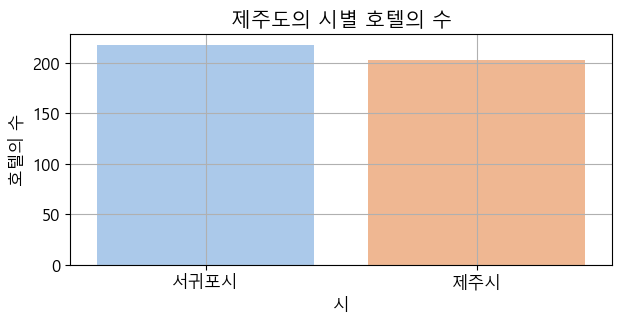

In [126]:
# 시 별 호텔의 수 그래프로 시각화
# si_df = data1에서 시 별로 호텔의 수를 count한 데이터 프레임

# 1) 그래프 전역 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (7,3)
plt.rcParams['axes.unicode_minus'] = False

# 2) 그래프 그리기
sb.barplot(data=si_df, x=si_df.index, y='count', palette='pastel')

plt.title("제주도의 시별 호텔의 수")
plt.xlabel("시")
plt.ylabel("호텔의 수")
plt.grid()
plt.show()
plt.close()

분석결과 : 제주도에는 제주시보다 서귀포시에 호텔의 수가 많다.

* 제주도 숙박 구분 그래프 (파이그래프)

In [127]:
# 구분 컬럼 = 파이그래프의 labels
labels = list(data1['콘텐츠분류'].unique())
labels

['관광호텔업', '한국전통호텔업', '가족호텔업', '호스텔업', '소형호텔업', '휴양콘도미니엄업']

In [128]:
# 파이그래프의 데이터
data = list(data1['콘텐츠분류'].value_counts())

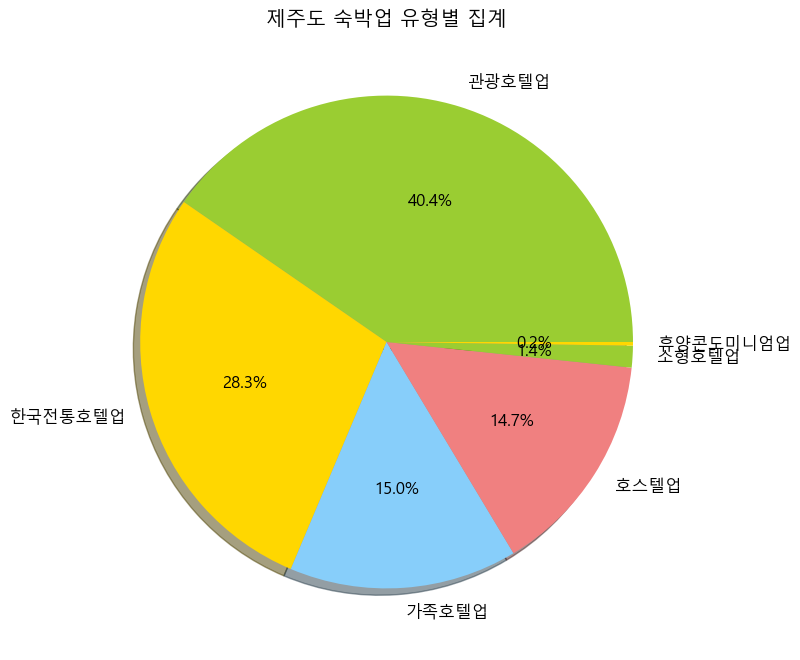

In [129]:
# 1) 그래프 전역 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['axes.unicode_minus'] = False

# 2) 파이그래프로 시각화

#데이터
data = list(data1['콘텐츠분류'].value_counts())

# 각 데이터별 레이블
labels = list(data1['콘텐츠분류'].unique())

# 각 데이터별 색상
colors = ['yellowgreen','gold','lightskyblue','lightcoral']

# 각 데이터별 확대비율
# explode = (0,0.0,0,0)

plt.figure()
plt.title("제주도 숙박업 유형별 집계")
plt.pie(data, labels=labels, colors=colors,
        autopct='%0.1f%%', startangle=0, shadow=True)
plt.show()
plt.close()

분석결과 : 제주도 숙박업을 유형별로 구분했을 때 관광호텔업 > 한국전통호텔업 > 가족호텔업 순으로 많았다.

* 제주도 숙소 유형별 객실수 분포 (hue파라미터 사용한 막대그래프)

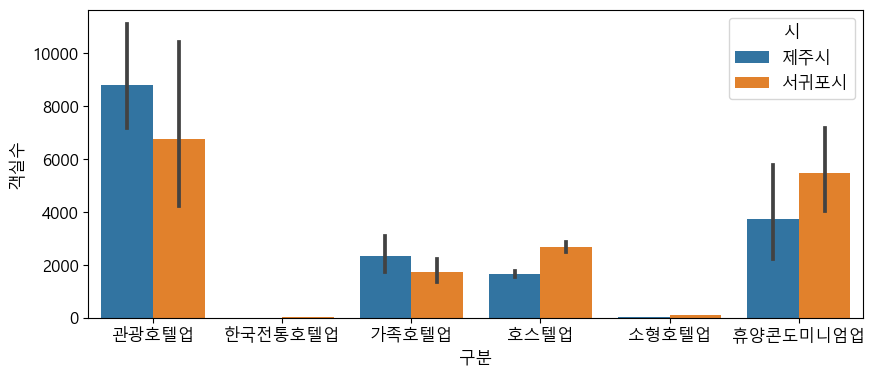

In [130]:
# 1) 그래프 전역 설정
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.unicode_minus"] = False

# 2) hue파라미터 사용하여 범주에 따라 구분 시각화 
sb.barplot(data=data1, x='구분', y='객실수', hue='시', estimator='sum')
plt.show()
plt.close()

분석결과 : 제주도의 제주시가 서귀포시보다 관광호텔업 유형이 많았지만, 휴양콘도미니엄업과 호스텔업의 경우 서귀포시가 제주시보다 많았다. <br> 

* 행정구역 별 숙박 및 관광지 분포도 시각화 그래프

In [ ]:
# 그래프 전역 설정
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["axes.unicode_minus"] = False

In [ ]:
# 데이터 불러오기
Data=pd.read_excel("./수정데이터/빅데이터.xlsx")
Data.drop(columns=sum([[Data.columns[0]],list(Data.columns[-4:-2])],[]),inplace=True)

In [ ]:
dt=pd.DataFrame(Data[(Data["콘텐츠분류"]=="숙박")|(Data["콘텐츠분류"]=="관광지")])

In [ ]:
# 행정구역으로 바꾸는 함수 사용 [*0단계 참고]

In [ ]:
plt.figure()
sb.countplot(data=숙박,
             x="행정구역",
             hue="콘텐츠분류")
plt.title("행정구역별 숙박 및 관광지 분포도")

![행정구역별숙박및관광지분포](./행정구역별숙박및관광지분포.png)

분석결과 : <br>
숙박보다 관광지 분포가 높은 곳은 표선, 조천, 동서귀, 구좌, 안덕, 중제주, 남원, 한림, 한경, 동제주이며 <br>
관광지보다 숙박의 분포가 높은 곳은 서제주, 애월, 중서귀이다. 

Text(0.5, 1.0, '행정구역별 숙박 및 관광지 분포도')

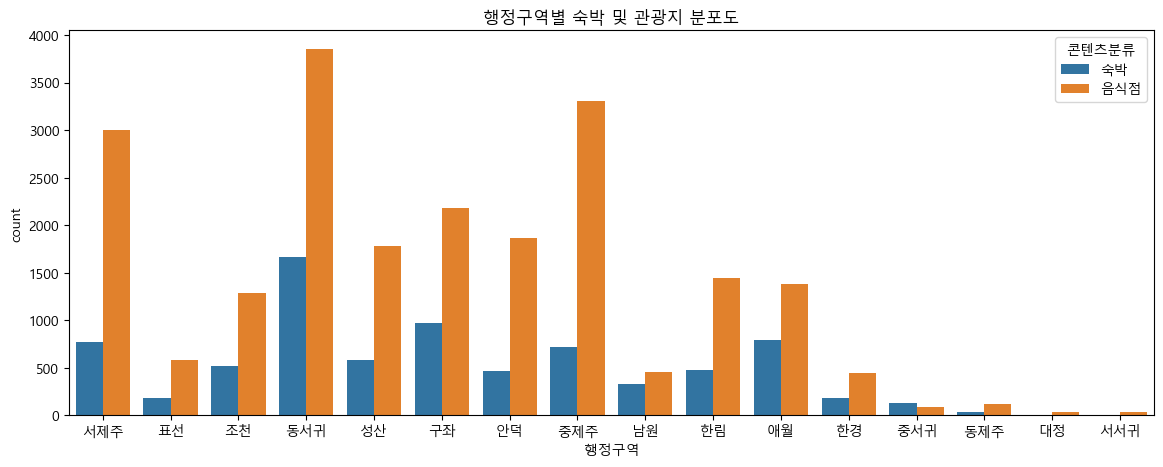

In [77]:
plt.figure()
sb.countplot(data=숙박,
             x="행정구역",
             hue="콘텐츠분류")
plt.title("행정구역별 숙박 및 관광지 분포도")

3.시각화
* 색상리스트 준비

In [ ]:
colors = ['#fffae6', '#ffeb99', '#ffdb4d', '#ffcc00', '#e6b800','#cca300','#997a00','#4d3d00']

* histogram 을 이용한 구간 설정

In [ ]:
# 행정구역이 index , 행정구역별 count값이 column
color_rule=pd.merge(pd.DataFrame(set(행정구역.values())).set_index(0),pd.DataFrame(data["행정구역"].value_counts()),
                    how="left",left_index=True,right_index=True).fillna(0)

# 히스토그램 구간 
x,y=np.histogram(color_rule["count"].values,bins=8)

# 구간 별 색상 
dc=dict(zip(y[:-1],colors))

# 행정구역 별 구간은 어디인지 
for name in color_rule.index:
    for i in y[:-1]:
        if color_rule.loc[name]['count']>=i:
            color_rule.loc[name,'color_id']=i

# svg 파일 열기
with open("./제주map.svg","r",encoding="utf-8") as f:
    jeju_map=f.readlines()

# svg파일의 색상을 color_rule의 color_id값으로 대체하기
for name in color_rule.index:
    idx=[]
    for i in range(len(jeju_map)):
        if name in jeju_map[i]:
            idx.append(i)
    for j in map(lambda x:x+1,idx):
        jeju_map[j]=jeju_map[j].replace("#eeeeee",dc[color_rule.loc[name]["color_id"]])

# 저장
with open("호텔시각화.html","w") as f:
    for line in jeju_map:
         f.write(line)

![행정구역별_호텔_밀집도](./호텔_시각화.png)

* 분석결과 
제주시, 애월읍, 동서귀포시에 호텔의 밀집도가 높았다. 

<span style = 'color:blue'> 7. 관광지SVG시각화와 호텔SVG시각화 비교 </span>

![관광지분포](./관광지_시각화.png)
<b>*[행정구역별 관광지 분포현황]*<b>
![호텔의분포](./호텔_시각화.png)
<b>*[행정구역별 호텔의 분포 현황]*<b>

* 관광지SVG시각화와 호텔SVG시각화 비교

`'동서귀포시'`에 호텔과 관광지가 밀집되어 있음을 알 수 있다. <br> 
또한 `제주도 지역의 중심부`에 관광지와 호텔이 많이 분포되어 있는데, 왜 이런 현상이 나타났을까? <br>
-> 가장 큰 이유는 `한라산` 때문이라고 할 수 있다. 제주도 중심에는 한라산이 위치해 있고 한라산을 찾는 관광객들이 가까운 숙소에 묵고, 숙소와 가까운 관광지를 찾는다고 볼 수 있을 것 같다. <br> 


<span style = 'color:blue'> 8. 음식점SVG시각화와 호텔SVG시각화 비교 </span>

![음식점_시각화](./음식점_시각화.png)
<b>*[행정구역별_음식점_분포도]*<b>
![호텔_시각화](./호텔_시각화.png)
<b>*[행정구역별_호텔_분포도]*<b>


* 음식점SVG시각화와 호텔SVG시각화 비교

`'동서귀포시'`에 호텔과 음식점이 밀집되어 있음을 알 수 있다. <br> 
또한 `제주도 지역의 중심부`에 음식점과 호텔이 많이 분포되어 있는데, 왜 이런 현상이 나타났을까? <br>
-> 가장 큰 이유는 앞서 말한 이유와 동일하다. 바로 `한라산` 때문이라고 할 수 있다. 제주도 중심에는 한라산이 위치해 있고 한라산을 찾는 관광객들이 가까운 숙소에 묵고, 숙소와 가까운 관광지를 찾는다고 볼 수 있을 것 같다. <br>
<br>
하지만 관광지 시각화와 다른 점이 있다. <br>
제주 조천읍, 구좌읍에는 호텔의 분포가 적은 반면, 음식점의 분포도가 높음을 알 수 있다. 왜 이런 현상이 나타났을까? <br>
-> 앞서 본 관광지시각화 그림을 보면 '조천읍','구좌읍'에 관광지 분포도가 높았다. 따라서 관광산업이 주인 제주도에서는 `관광객`을 타켓층으로 음식점이 많이 분포되어 있음을 알 수 있다.

### <span style= 'color : blue' > *4단계 : 상관관계 분석* </span>

<span style = 'font-size: 25px'><b> 1. 소비자의 `만족도`를 `평점`이라고 가정<b> </span><br>

<br>

-<b>*만족도를 결정하는 외부적인 요인과의 상관관계 분석*<b><br>
|단계|가설|
|----|---|
|`1`| 호텔의 수와 제주공항과의 거리의 관계 : 거리에 따른 호텔 수의 분포도|<br>
|`2`| 호텔 평점과 제주공항과의 거리의 관계 : 거리에 따른 호텔 평점 별 분포도 | <br>
|`3`| 행정구역 별 호텔의 평균 평점과 동일 행정구역 내 관광지의 개수의 관계 : 행정구역 내 관광지의 수가 많을 수록 행정구역 별 평균 평점이 높은가?|<br>
|`4`| 행정구역 별 호텔의 평균 평점과 동일 행정지역 내의 음식점 개수의 관계 : 행정구역 내 음식점의 수가 많을 수록 행정구역 별 평균 평점이 높은가?|<br>

<span style = 'font-size: 25px'><b> 2. 제주공항의 거리에 따른 호텔 수의 분포도<b></span>

* 카카오맵을 이용한 소요시간 측정 함수 - `0단계 참조`

* 시각화

In [24]:
# 그래프 전역 설정
plt.rcParams["font.family"] = 'Malgun Gothic'
#plt.rcParams["font.family"] = 'AppleGothic'
plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["axes.unicode_minus"] = False

In [25]:
Data=pd.read_excel("./수정데이터/빅데이터.xlsx")

In [26]:
Data.drop(columns=sum([[Data.columns[0]],list(Data.columns[-4:-2])],[]),inplace=True)

In [27]:
숙박=pd.DataFrame(Data[Data["콘텐츠분류"]=="숙박"])

In [28]:
#평점 전처리 -> 0으로 대체
print(숙박["평점"].isna().sum())
숙박["평점"].fillna(0,inplace=True)

707


In [29]:
#거리 전처리 -> 제거
print(숙박["거리(m)"].isna().sum())
temp=숙박[숙박["거리(m)"].isna()==False]

78


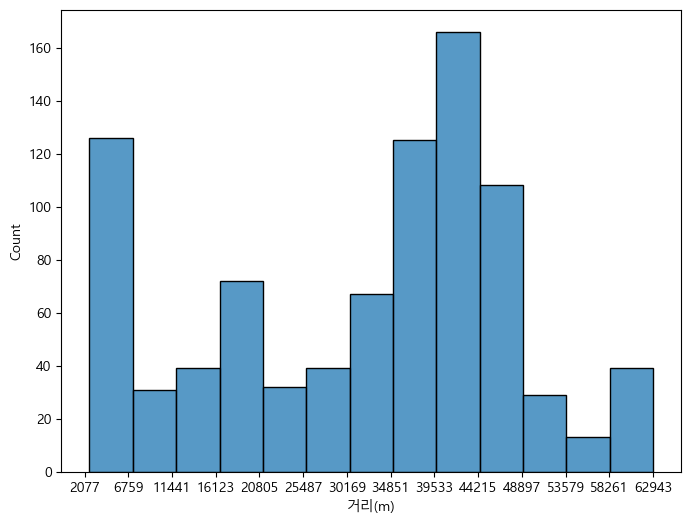

In [32]:
plt.rcParams["figure.figsize"] = (8, 6)
x,y=np.histogram(temp["거리(m)"],bins=13)
plt.figure()
sb.histplot(data=temp.loc[temp["평점"]==0,'거리(m)'],
            bins=13)
plt.xticks(y)
plt.show()

<span style = 'font-size: 25px'><b> 3. 평점 데이터 불러오기 : `0단계 통합데이터 참조`<b></span>

<span style = 'font-size: 25px'><b> 4. 제주공항 거리에 따른 호텔 평점 별 거리분포도 <b></span>

In [33]:
list(숙박["평점"].unique()).sort()

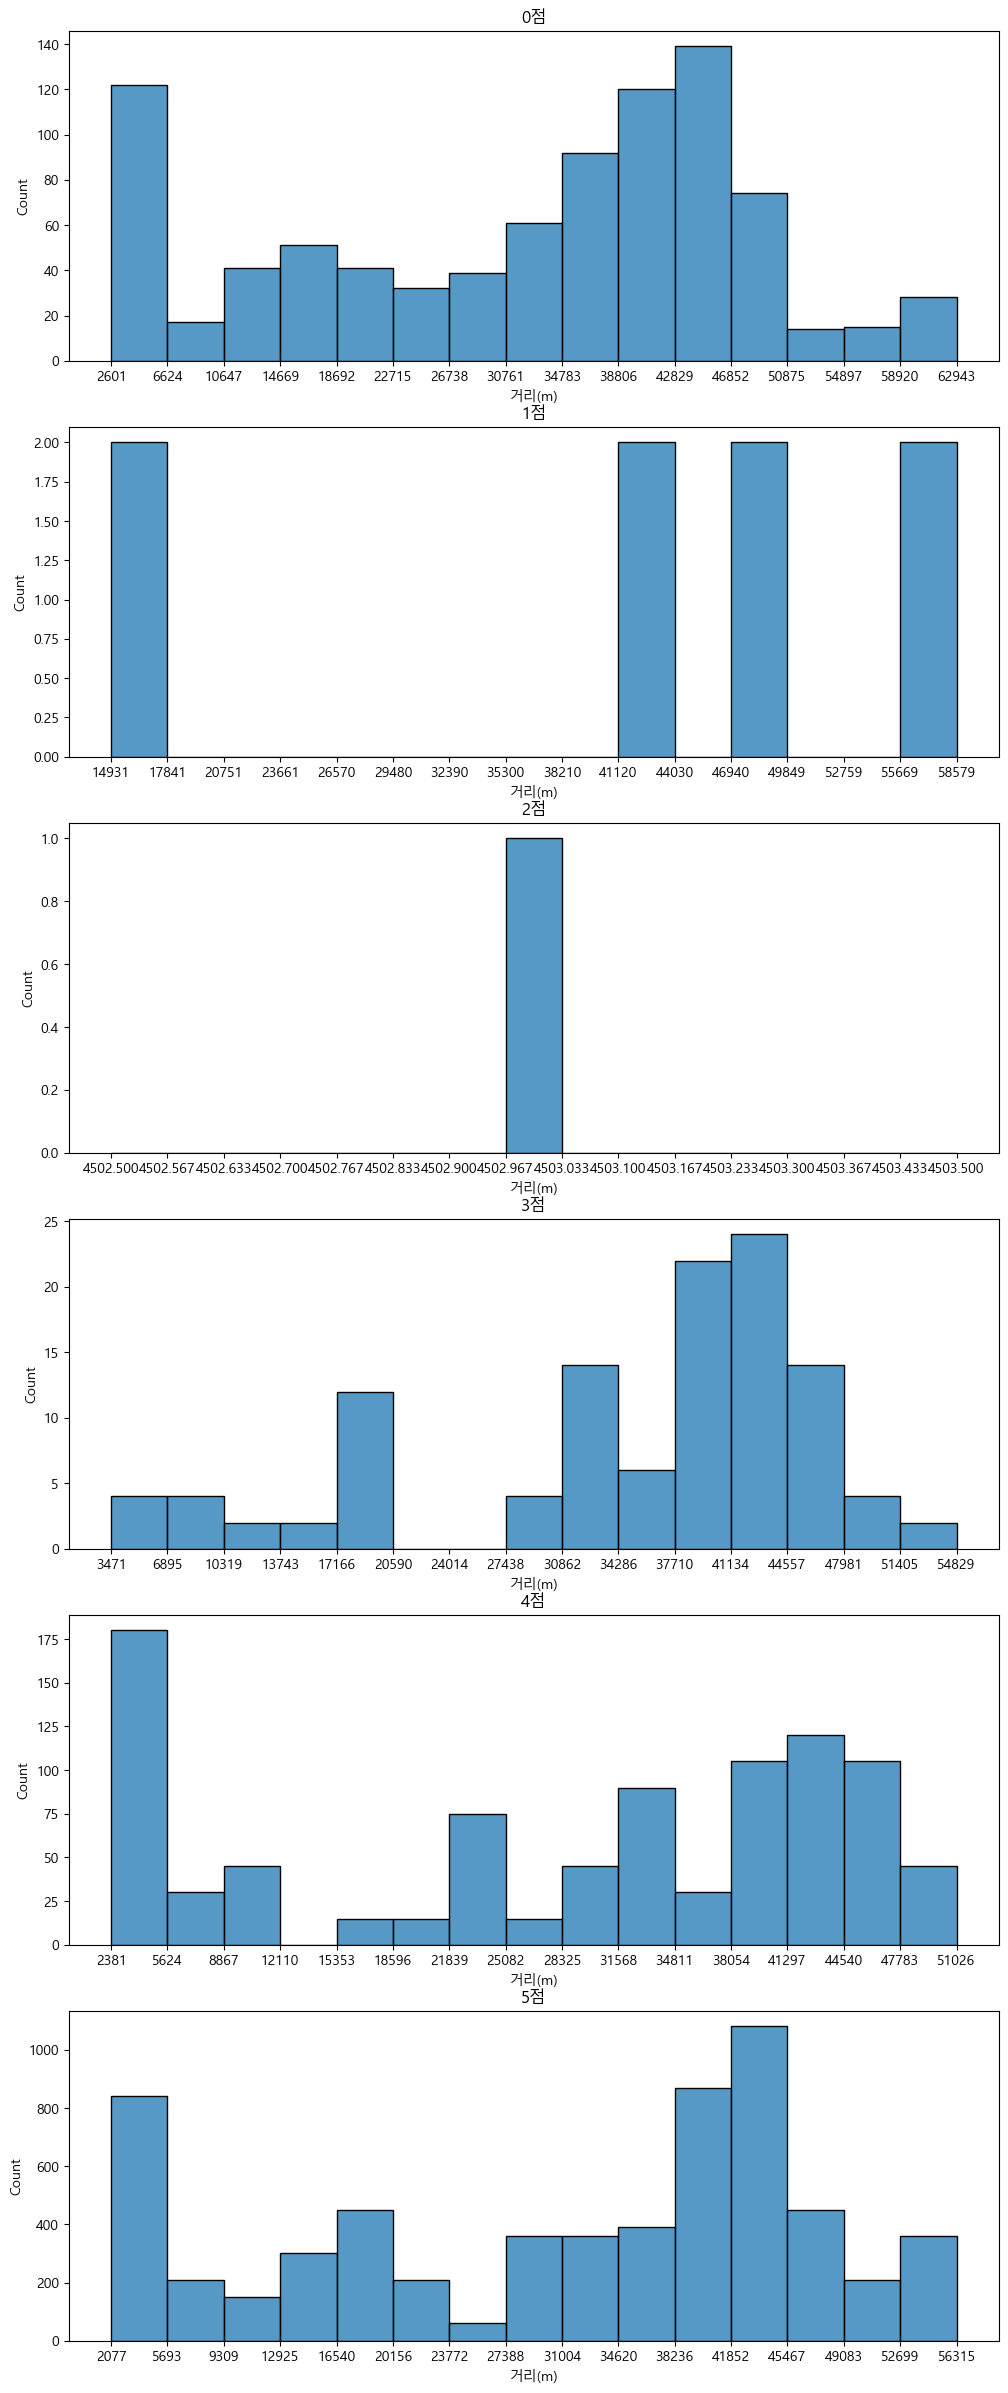

In [34]:
plt.rcParams["figure.figsize"] = (12, 30)
fig,AX=plt.subplots(6,1)
Xs=list(숙박["평점"].unique())
Xs.sort()
dt=list(AX)
#DT=[x for x in AX]
#dt=sum([[x[0],x[1]] for x in DT],[])
num=15

xt={}
for i,j in enumerate(dt):
    x,y=np.histogram(temp.loc[temp["평점"]==i,'거리(m)'],bins=num)
    sb.histplot(ax=j
        ,data=temp.loc[temp["평점"]==i,'거리(m)'],
            bins=num)
    xt[j]=y
#꾸미기#
name=dict(zip(dt,["0점","1점","2점","3점","4점","5점"]))
for z in name:
    z.title.set_text(f"{name[z]}")
    z.set_xticks(xt[z])
        # DT[y][i].set_xticks(None)
plt.show()
plt.close()

<span style = 'font-size: 25px'><b> 5. 행정구역 별 호텔의 평균 평점과 동일 행정구역 내 관광지의 개수의 관계 : 행정구역 내 관광지의 수가 많을 수록 평점이 높은가?<br>  <b></span>

In [48]:
# 그래프 전역 설정
plt.rcParams["font.family"] = 'Malgun Gothic'
#plt.rcParams["font.family"] = 'AppleGothic'
plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["axes.unicode_minus"] = False

In [49]:
# 데이터 불러오기
Data=pd.read_excel("./수정데이터/빅데이터.xlsx")
Data.drop(columns=sum([[Data.columns[0]],list(Data.columns[-4:-2])],[]),inplace=True)

In [50]:
dt=pd.DataFrame(Data[(Data["콘텐츠분류"]=="숙박")|(Data["콘텐츠분류"]=="관광지")])

In [51]:
# 행정구역으로 바꾸는 함수 참조

In [56]:
dt2=pd.DataFrame(숙박.groupby(["행정구역","콘텐츠분류"])["평점"].mean()).unstack()

<Axes: xlabel="('평점', '관광지')", ylabel="('평점', '숙박')">

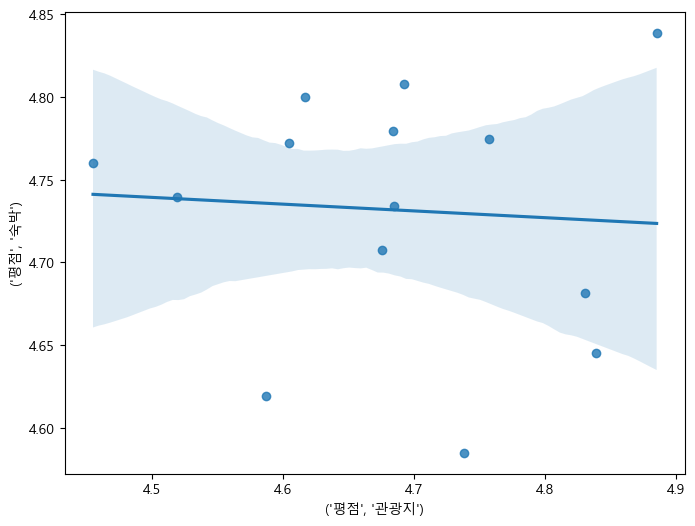

In [57]:
plt.rcParams["figure.figsize"] = (8, 6)
sb.regplot(x=dt2[dt2.columns[0]],
            y=dt2[dt2.columns[1]])

In [58]:
dt3=pd.DataFrame(숙박[숙박["콘텐츠분류"]=="숙박"].groupby(["행정구역"])["평점"].mean())
dt3=dt3.rename(columns={"평점": "평균평점"})
dt3_1=pd.DataFrame(숙박[숙박["콘텐츠분류"]=="관광지"].groupby(["행정구역"])["타이틀"].count())
dt3_1.rename(columns={"타이틀":"관광지개수"},inplace=True)
data3_2=pd.merge(dt3.reset_index(),dt3_1.reset_index()).set_index("행정구역",drop=True)

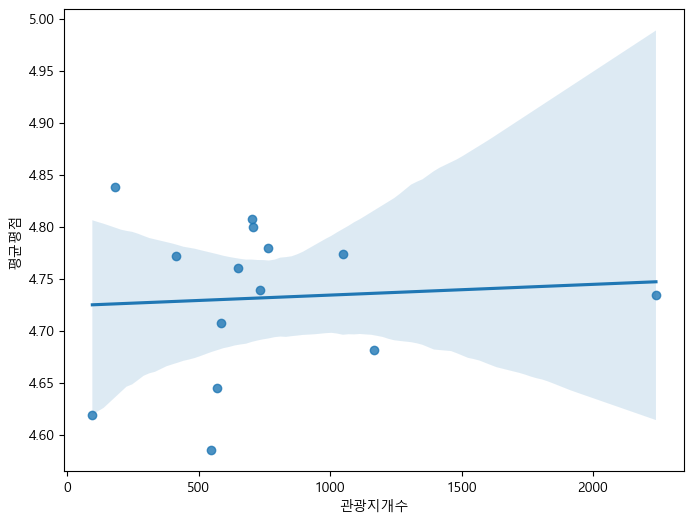

In [59]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.figure()
sb.regplot(x=data3_2[data3_2.columns[1]],
            y=data3_2[data3_2.columns[0]])
plt.show()

In [60]:
dt4=pd.DataFrame(숙박.groupby(["행정구역","콘텐츠분류"])["타이틀"].count()).unstack()

In [61]:
dt4=pd.DataFrame(dt4)

Text(0, 0.5, '숙박업평점')

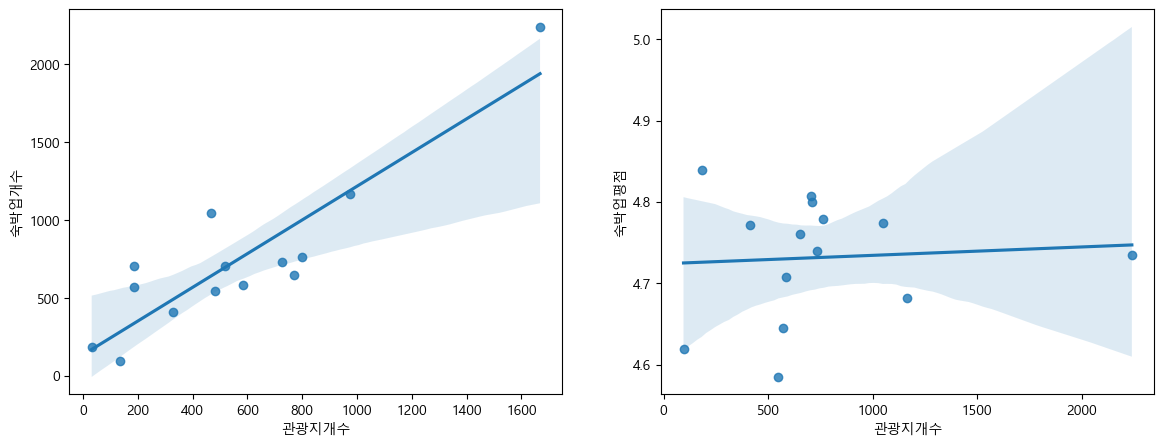

In [62]:
plt.rcParams["figure.figsize"] = (14, 5)
x,y=plt.subplots(1,2)
sb.regplot(ax=y[0],
    x=dt4[dt4.columns[1]],
            y=dt4[dt4.columns[0]])
sb.regplot(ax=y[1],
    x=data3_2[data3_2.columns[1]],
            y=data3_2[data3_2.columns[0]])
y[0].set_xlabel("관광지개수")
y[0].set_ylabel("숙박업개수")
y[1].set_xlabel("관광지개수")
y[1].set_ylabel("숙박업평점")

<span style = 'font-size:25px'> <b> 6. 호텔 평점과 동일 행정지역 내의 음식점 개수의 관계 : 행정구역 내 음식점의 수가 많을 수록 평점이 높은가?<b></span>

In [63]:
plt.rcParams["font.family"] = 'Malgun Gothic'
#plt.rcParams["font.family"] = 'AppleGothic'
plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["axes.unicode_minus"] = False

In [64]:
Data=pd.read_excel("./수정데이터/빅데이터.xlsx")
Data.drop(columns=sum([[Data.columns[0]],list(Data.columns[-4:-2])],[]),inplace=True)

In [65]:
dt=pd.DataFrame(Data[(Data["콘텐츠분류"]=="숙박")|(Data["콘텐츠분류"]=="음식점")])

In [ ]:
# 행정구역으로 바꾸는 함수 참조

Text(0, 0.5, '숙박업')

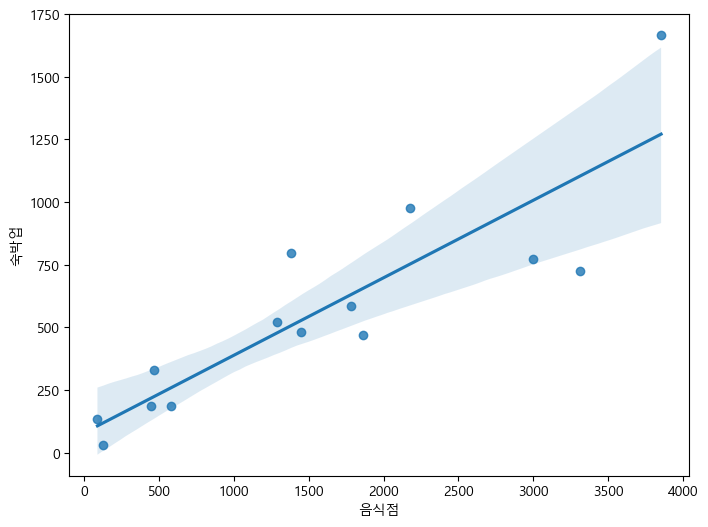

In [73]:
plt.rcParams["figure.figsize"] = (8, 6)
sb.regplot(x=dt2[('타이틀', '음식점')],
            y=dt2[('타이틀', '숙박')])
plt.xlabel("음식점")
plt.ylabel("숙박업")

In [74]:
dt3=pd.DataFrame(숙박.groupby(["행정구역"])["평점"].mean())
dt3=dt3.rename(columns={"평점": "평균평점"})
dt3_1=pd.DataFrame(숙박[숙박["콘텐츠분류"]=="음식점"].groupby(["행정구역"])["타이틀"].count())
dt3_1.rename(columns={"타이틀":"음식점개수"},inplace=True)
data3_2=pd.merge(dt3.reset_index(),dt3_1.reset_index()).set_index("행정구역",drop=True)

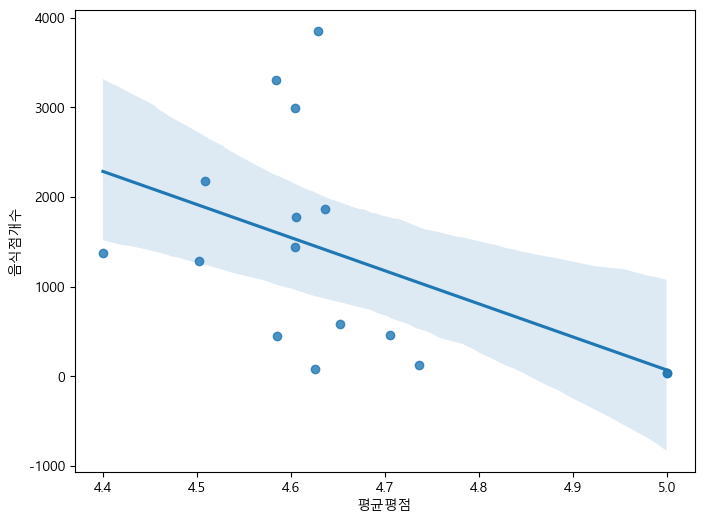

In [75]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.figure()
sb.regplot(x=data3_2[data3_2.columns[0]],
            y=data3_2[data3_2.columns[1]])
plt.show()

Text(0, 0.5, '숙박업평점')

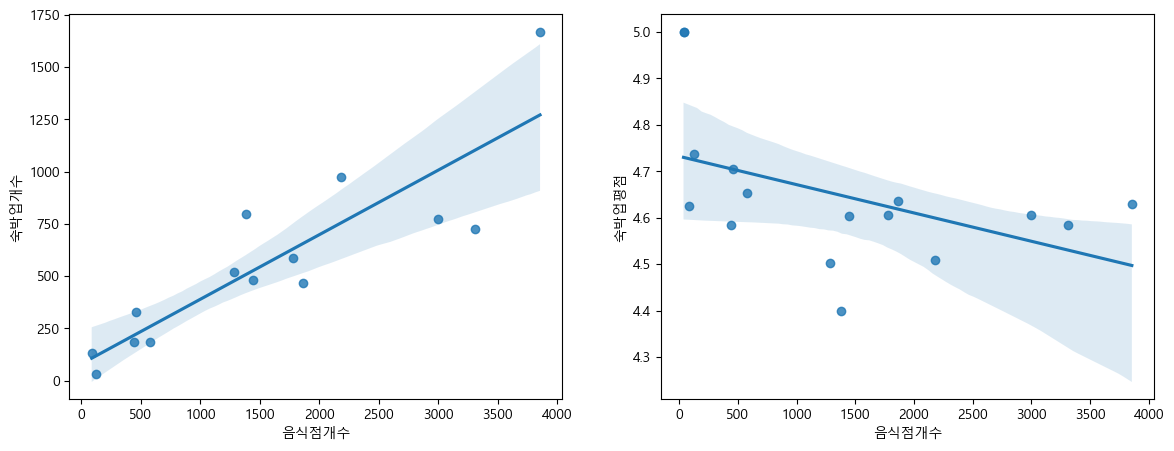

In [76]:
plt.rcParams["figure.figsize"] = (14, 5)
x,y=plt.subplots(1,2)
sb.regplot(ax=y[0],
    x=dt2[('타이틀', '음식점')],
            y=dt2[('타이틀', '숙박')])
sb.regplot(ax=y[1],
           x=data3_2[data3_2.columns[1]],
            y=data3_2[data3_2.columns[0]])
y[0].set_xlabel("음식점개수")
y[0].set_ylabel("숙박업개수")
y[1].set_xlabel("음식점개수")
y[1].set_ylabel("숙박업평점")

*********************

<span style = 'font-size:40px'><b> 3. 분석결과</span>

> 1. 호텔의 수와 제주공항과의 거리의 관계 : 거리에 따른 호텔 수의 분포도

시각화 분석결과 : 제주공항과의 거리가 가까우면 호텔의 수가 많았지만, 호텔이 가장 많이 있는 곳은 공항으로부터 39533~44215m거리에 있었다. 

> 2. 제주공항과의 거리에 따른 호텔의 평점 별 거리분포도

제주공항과 거리가 가까울 수록 호텔의 평점 4~5점 분포도가 높았다. 

> 3. 행정구역 별 호텔의 평균 평점과 동일 행정구역 내 관광지의 개수의 관계 : 행정구역 내 관광지의 수가 많을 수록 평점이 높은가? <br>
> 4. 호텔 평점과 동일 행정지역 내의 음식점 개수의 관계 : 행정구역 내 음식점의 수가 많을 수록 평점이 높은가?

큰 상관관계를 확인하지 못했다. 같은 행정구역에 위치한 음식점의 수, 관광지의 수, 관광지의 평균 평점 모두 낮은 상관관계를 보여주었다. 하지만 추가로 조사한 관광지의 수, 음식점의 수와 숙박업의 수에서의 상관관계가 있어보인다. 

**************

<span style = 'font-size:40px'><b> 4. 결론 <b></span>

숙박업의 소비자 만족도(평점)과 외부적인 요인의 연관성을 찾지 못했으나, 숙박업의 수와의 관계성을 찾게 되었다. 